First, load the data, from the supplied data file

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import regex as re
import seaborn as sns


import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

In [2]:
# Import the data
df = pd.read_csv("../data/artist_data.csv")  #..(relative path, goes to the parent directory) vs. C:Users (absolute path)


In [3]:
# Set some global options so we always see all of the columns and rows when we print something out
pd.set_option('display.max_columns', 100) # 100 cols
pd.set_option('display.max_rows', 50) # 50 rows

In [4]:
print(df.head)

<bound method NDFrame.head of          id                    name  gender      dates  yearOfBirth   
0     10093  Abakanowicz, Magdalena  Female  born 1930       1930.0  \
1         0     Abbey, Edwin Austin    Male  1852–1911       1852.0   
2      2756        Abbott, Berenice  Female  1898–1991       1898.0   
3         1  Abbott, Lemuel Francis    Male  1760–1803       1760.0   
4       622          Abrahams, Ivor    Male  born 1935       1935.0   
...     ...                     ...     ...        ...          ...   
3527  12542         Zorio, Gilberto    Male  born 1944       1944.0   
3528   2186              Zox, Larry    Male  born 1936       1936.0   
3529    621   Zuccarelli, Francesco    Male  1702–1788       1702.0   
3530   2187        Zuloaga, Ignacio    Male  1870–1945       1870.0   
3531   2188         Zyw, Aleksander    Male  1905–1995       1905.0   

      yearOfDeath                    placeOfBirth            placeOfDeath   
0             NaN                       

In [5]:
# Shape and data types of the data
print(df.shape) 
print("The dataframe has",df.shape[0],"rows and", df.shape[1],"columns")
print(df.dtypes) # The data types of all of the columns

# select numeric columns
df_numeric = df.select_dtypes(include=[np.number]) # Select numeric data types
numeric_cols = df_numeric.columns.values # Give the column names to a new variable
print("The column names are",df.columns.values)
print("The numeric columns are", numeric_cols)

# select non numeric columns
df_non_numeric = df.select_dtypes(exclude=[np.number])
non_numeric_cols = df_non_numeric.columns.values
print("The non-numeric columns are",non_numeric_cols)

(3532, 9)
The dataframe has 3532 rows and 9 columns
id                int64
name             object
gender           object
dates            object
yearOfBirth     float64
yearOfDeath     float64
placeOfBirth     object
placeOfDeath     object
url              object
dtype: object
The column names are ['id' 'name' 'gender' 'dates' 'yearOfBirth' 'yearOfDeath' 'placeOfBirth'
 'placeOfDeath' 'url']
The numeric columns are ['id' 'yearOfBirth' 'yearOfDeath']
The non-numeric columns are ['name' 'gender' 'dates' 'placeOfBirth' 'placeOfDeath' 'url']


Identify missing data 

<Axes: >

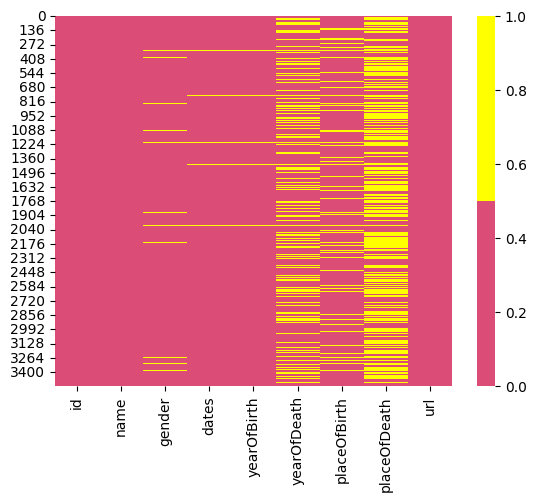

In [6]:
cols = df.columns[:30] # Select the first 30 columns
colours = ['#db4c77', '#ffff00'] # Specify the colours, where yellow is missing and pink is not missing.
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours)) # Make a heatmap


Some colums are not too important in this analysis, therefore I am going to drop the 'Place of death' and 'Year of Death' and 'url'.

In [7]:
cols_to_drop = ['placeOfDeath', 'url', 'yearOfDeath', 'id', 'dates']
df_col_dropped = df.drop(cols_to_drop, axis=1)
df_col_dropped

,name,gender,yearOfBirth,placeOfBirth
0,"Abakanowicz, Magdalena",Female,1930.0,Polska
1,"Abbey, Edwin Austin",Male,1852.0,"Philadelphia, United States"
2,"Abbott, Berenice",Female,1898.0,"Springfield, United States"
3,"Abbott, Lemuel Francis",Male,1760.0,"Leicestershire, United Kingdom"
4,"Abrahams, Ivor",Male,1935.0,"Wigan, United Kingdom"
...,...,...,...,...
3527,"Zorio, Gilberto",Male,1944.0,"Andorno Micca, Italia"
3528,"Zox, Larry",Male,1936.0,"Des Moines, United States"
3529,"Zuccarelli, Francesco",Male,1702.0,Italia
3530,"Zuloaga, Ignacio",Male,1870.0,España


Checking if the gender collum has any has outliers

<Axes: >

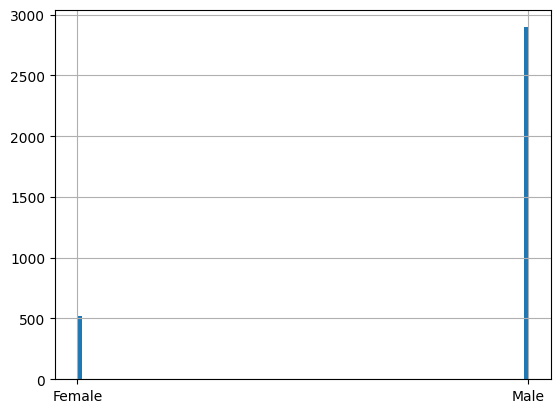

In [8]:
# Histogram
df['gender'].hist(bins=100)

<Axes: >

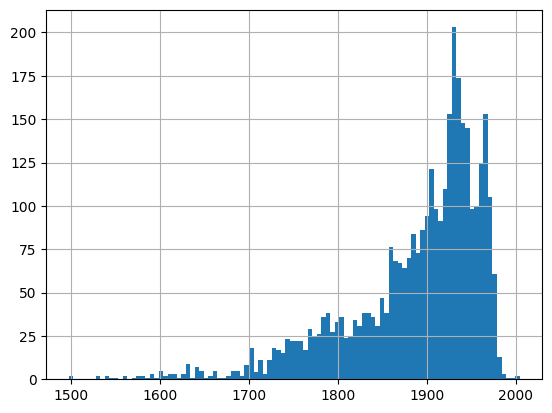

In [9]:
# Histogram
df['yearOfBirth'].hist(bins=100)

Checking if the cases are in the same capital letters and no spelling mistakes.

In [10]:
df['gender'].value_counts(dropna=False)

gender
Male      2895
Female     521
NaN        116
Name: count, dtype: int64

Reduce the number of categories for 'placeOfBirth, keep only the top 10 places with most data, and label the rest as 'Other'

In [33]:
top_places = df['placeOfBirth'].value_counts().index[:10]
df['placeOfBirth'] = df['placeOfBirth'].where(df['placeOfBirth'].isin(top_places), 'Other')

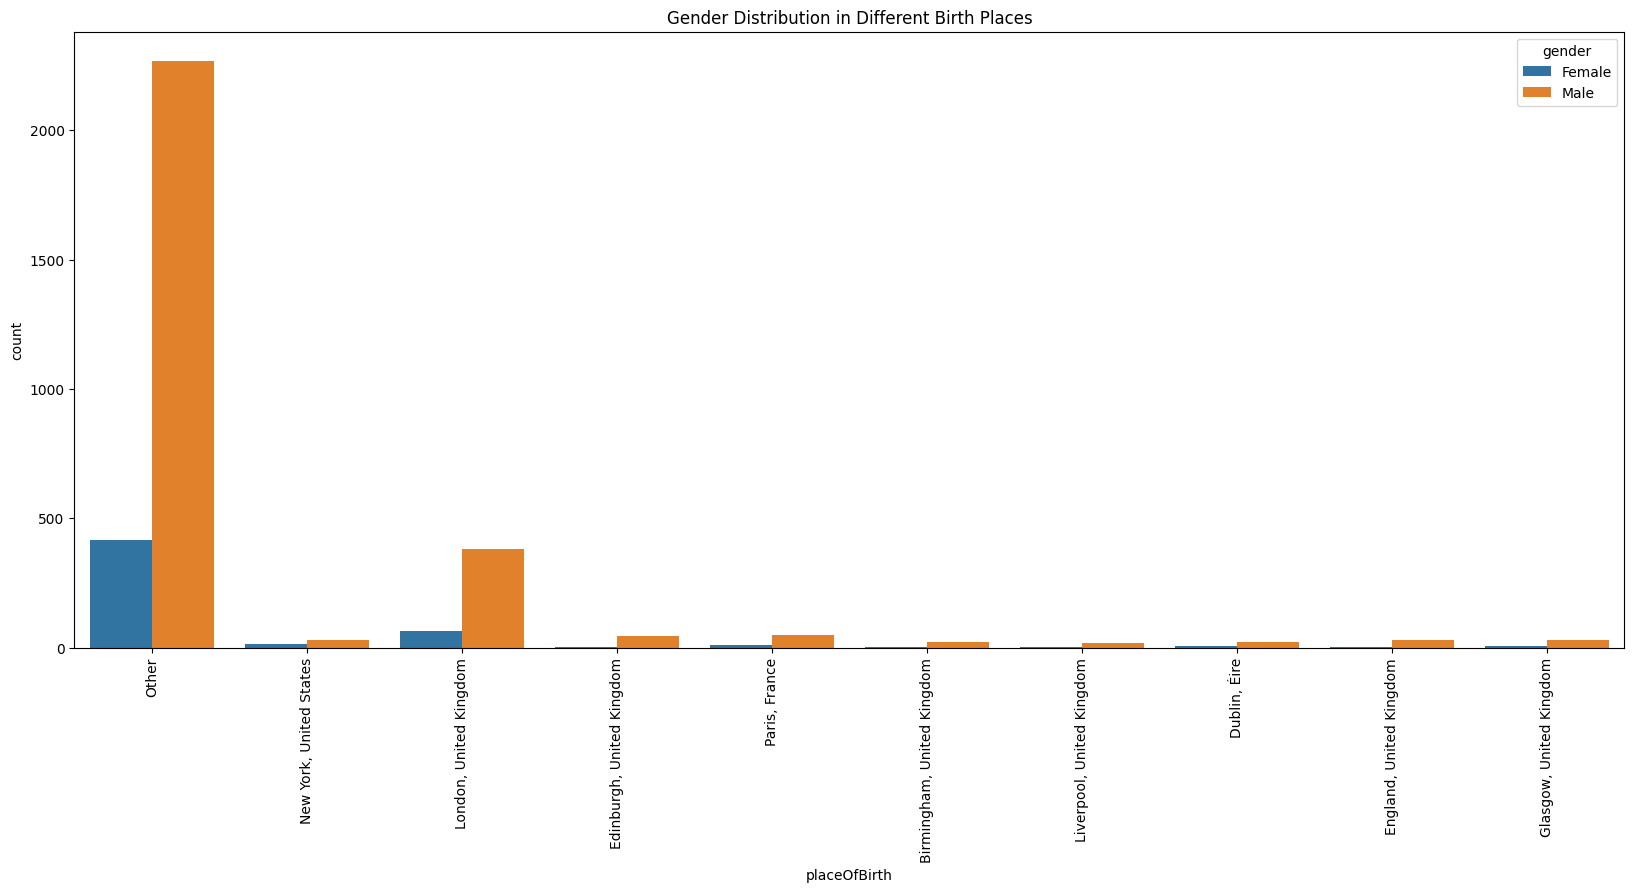

In [34]:
# Count Plot
plt.figure(figsize=(20, 8))
sns.countplot(data=df, x='placeOfBirth', hue='gender')
plt.xticks(rotation=90)
plt.title("Gender Distribution in Different Birth Places")
plt.show()

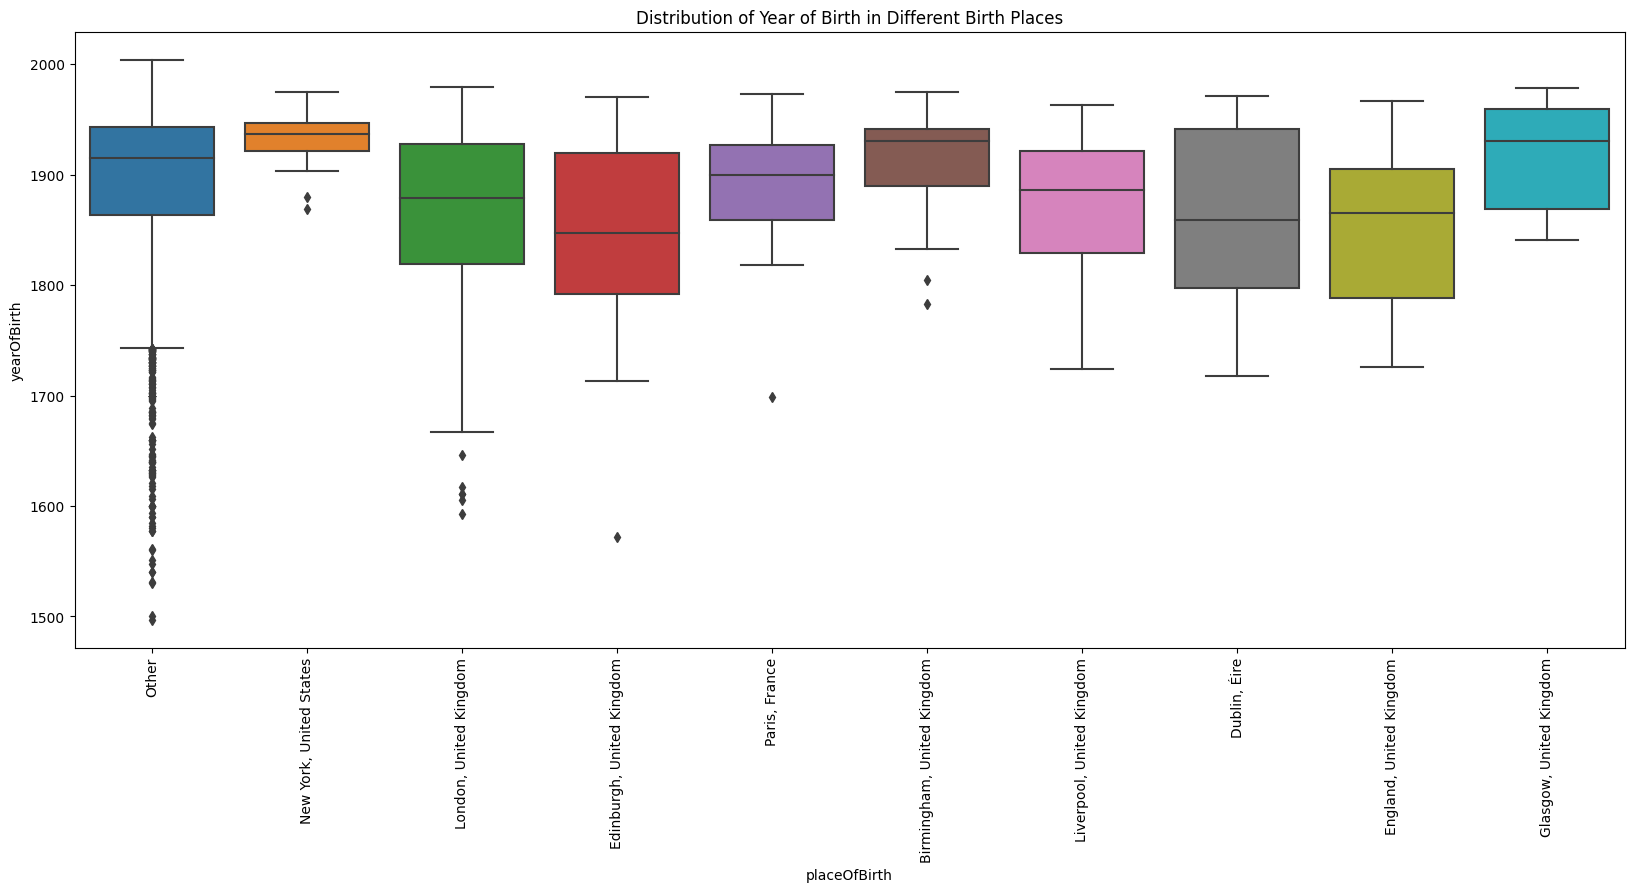

In [35]:
# Box Plot
plt.figure(figsize=(20, 8))
sns.boxplot(data=df, x='placeOfBirth', y='yearOfBirth')
plt.xticks(rotation=90)
plt.title("Distribution of Year of Birth in Different Birth Places")
plt.show()

In [42]:
# Create a geolocator using Nominatim
geolocator = Nominatim(user_agent="geoapiExercises")

In [43]:
# Create a rate limiter using the geolocator
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

In [44]:
# Apply the geolocator to 'placeOfBirth', save the location information to a new column
df['location'] = df['placeOfBirth'].apply(geocode)

In [45]:
# Extract latitude, longitude and altitude from location, and save them to new columns
df['point'] = df['location'].apply(lambda loc: tuple(loc.point) if loc else None)
df[['latitude', 'longitude', 'altitude']] = pd.DataFrame(df['point'].tolist(), index=df.index)


C:\Users\jenny\AppData\Local\Temp\ipykernel_18716\3089003449.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


      id                    name  gender      dates  yearOfBirth  yearOfDeath   
0  10093  Abakanowicz, Magdalena  Female  born 1930       1930.0          NaN  \
1      0     Abbey, Edwin Austin    Male  1852–1911       1852.0       1911.0   
2   2756        Abbott, Berenice  Female  1898–1991       1898.0       1991.0   
3      1  Abbott, Lemuel Francis    Male  1760–1803       1760.0       1803.0   
4    622          Abrahams, Ivor    Male  born 1935       1935.0          NaN   

  placeOfBirth            placeOfDeath   
0        Other                     NaN  \
1        Other  London, United Kingdom   
2        Other   Monson, United States   
3        Other  London, United Kingdom   
4        Other                     NaN   

                                                 url   
0  http://www.tate.org.uk/art/artists/magdalena-a...  \
1  http://www.tate.org.uk/art/artists/edwin-austi...   
2  http://www.tate.org.uk/art/artists/berenice-ab...   
3  http://www.tate.org.uk/art/artist

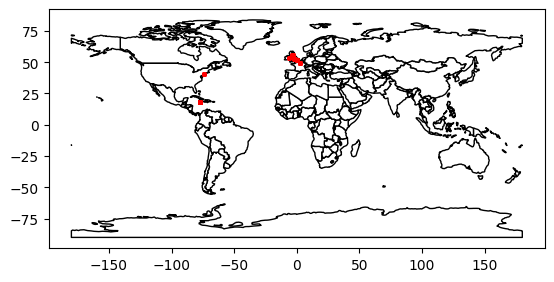

In [53]:
# Load a map of the world
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Create a GeoDataFrame from your data
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

# Print out first few records of gdf
print(gdf.head())

# Plot the world
base = world.plot(color='white', edgecolor='black')

# Plot your data on top of the world map
gdf.plot(ax=base, marker='o', color='red', markersize=5)

plt.draw()
plt.show()
